In [1]:
import numpy as np
import pdb

from functools import reduce
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [2]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest
sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 1000

# nu is the ratio of noise to data samples in NCE
nu = 1

In [4]:
#observed data
z = rnd.uniform(0,1, n) > 0.5 
x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)) 

#noise
y = sigma0 * rnd.randn(n*nu)  

In [5]:
thetas = np.arange(0.01, 8, 0.1)
n_theta = len(thetas)
thetas_small = thetas[::2]
n_theta_small = len(thetas_small)

# correctly normalised model
pm = lambda u, theta: 0.5*(norm.pdf(u,0,theta)+norm.pdf(u, 0, sigma1))
# noise that matches the larger std
pn = lambda u: norm.pdf(u,0, sigma0) 
# quick hack: generally better to work in log domain!
h = lambda u, theta: np.log(pm(u, theta)/pn(u)) 

J = np.zeros(n_theta)
for k in range(n_theta):
    theta_k = thetas[k]
    a0 = 1 + nu*np.exp(-h(x,theta_k))
    a1 = 1 + (1/nu)*np.exp(h(y,theta_k))
    J[k] = -np.mean(np.log(a0)) - nu*np.mean(np.log(a1))

In [6]:
eps = 10**-15

#q0 = lambda u, alpha:  1 / (1 + (alpha/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/alpha**2)))
q0 = lambda u, alpha: norm.pdf(u, 0, alpha) / (norm.pdf(u, 0, alpha) + norm.pdf(u, 0, sigma1))
q1 = lambda u, alpha: 1 - q0(u, alpha) 

phi0 = lambda u, theta:  0.5*norm.pdf(u, 0, theta)
phi1 = lambda u, theta:  0.5*norm.pdf(u, 0, sigma1)

r0 = lambda u, theta, alpha: phi0(u, theta)/( q0(u, alpha)*pn(u) + eps)
r1 = lambda u, theta, alpha: phi1(u, theta)/( q1(u, alpha)*pn(u) + eps)

In [7]:
def r(u, z, theta, alpha):
    term1 = (z==0)*r0(u, theta, alpha)
    term2 = (z==1)*r1(u, theta, alpha)
    return term1 + term2

In [8]:
def compute_J1(x, y, zx, zy, theta, alpha):
    '''Compute J1 using a monte carlo estimate'''
    a0 = nu/(r(x, zx, theta, alpha) + eps) 
    a1 = (1/nu) * np.mean(r(y, zy, theta, alpha), axis=0)
    
    first_term = -np.mean(np.log(1 + a0))
    second_term = -nu*np.mean(np.log(1 + a1))
    
    return first_term, second_term

In [9]:
degree = 3

def make_poly_design_matrix(u, deg):
    u = u.reshape(-1)
    U = np.zeros((len(u), deg))
    for i in range(deg):
        U[:, i] = u**i  
    return U

def sigmoid(u):
    return  1/(1 + np.exp(-u))

def q0_var(u, w):
    U = make_poly_design_matrix(u, degree)
    return sigmoid(np.dot(U,w))

q1_var = lambda u, w: 1 - q0_var(u, w)
r0_var = lambda u, theta, w: phi0(u, theta)/( q0_var(u, w)*pn(u) + eps)
r1_var = lambda u, theta, w: phi1(u, theta)/( q1_var(u, w)*pn(u) + eps)

In [10]:
def compute_J1_analytic(x, y, theta, w):
    '''Computes J1 by by analytically solving the expectations'''
    # first term
    a0 = nu/(r0_var(x, theta, w) + eps)
    a1 = nu/(r1_var(x, theta, w) + eps)
    first_term = -np.mean(q0_var(x, w)*np.log(1 + a0) + q1_var(x, w)*np.log(1 + a1))      
    
    # second term
    m = q0_var(y, w)*r0_var(y, theta, w) + q1_var(y, w)*r1_var(y, theta, w)
    second_term = - nu*np.mean(np.log(1 + (1/nu)*m)) 
    
    return  first_term, second_term

In [11]:
J1s_mc_1 = np.zeros(n_theta_small)
J1s_mc_2 = np.zeros(n_theta_small)

J1s_analytic_1 = np.zeros(n_theta_small) 
J1s_analytic_2 = np.zeros(n_theta_small) 

alpha = 4   
zx = np.zeros((n, n))
zy = np.zeros((n, n))
for j in range(n):
    zx[:,j] = rnd.uniform(0, 1, n) < q1(x[j], alpha)
    zy[:,j] = rnd.uniform(0, 1, n) < q1(y[j], alpha)  
     
for i in range(n_theta_small):
    theta = thetas_small[i]
    #zx = rnd.uniform(0, 1, n) < q1(x, alpha)
    #zy = rnd.uniform(0, 1, n) < q1(y, alpha)  
    w = np.array([-np.log(alpha), 0, (1/2)*(1-alpha**(-2))])
    
    #print(np.allclose(q0_var(x, w), q0(x, alpha).reshape(-1)))
    #print(compute_J1(x, y, zx, zy, theta, alpha), compute_J1_analytic(x, y, theta, w))
    
    J1s_mc_1[i], J1s_mc_2[i] = compute_J1(x, y, zx, zy, theta, alpha)
    J1s_analytic_1[i], J1s_analytic_2[i] = compute_J1_analytic(x, y, theta, w)

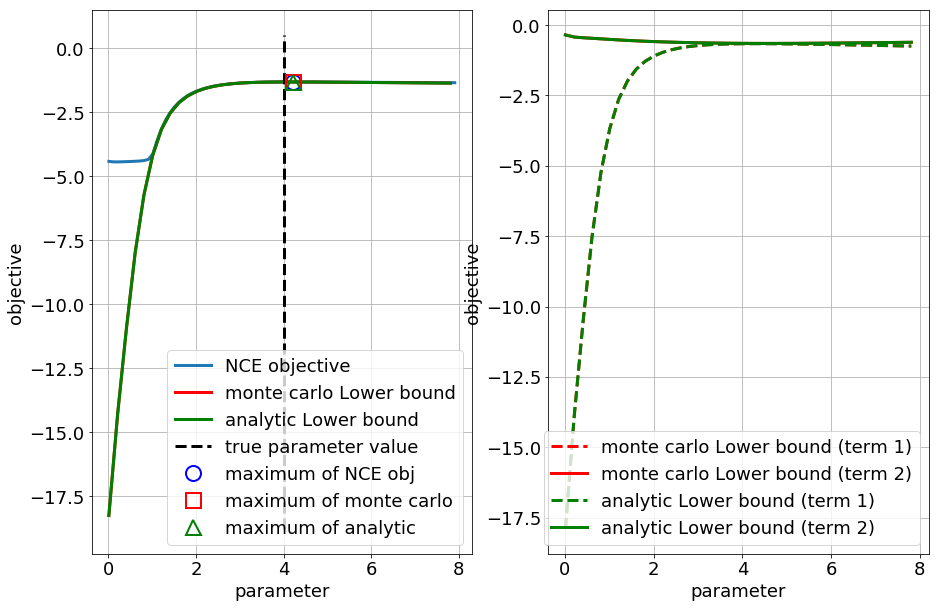

In [12]:
J1s_mc = J1s_mc_1 + J1s_mc_2
J1s_analytic = J1s_analytic_1 + J1s_analytic_2

fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs = axs.ravel()
axs[0].plot(thetas, J, label='NCE objective')
axs[0].plot(thetas_small, J1s_mc, 'r', label='monte carlo Lower bound')
axs[0].plot(thetas_small, J1s_analytic, 'g', label='analytic Lower bound')
axs[1].plot(thetas_small, J1s_mc_1, 'r--', label='monte carlo Lower bound (term 1)')
axs[1].plot(thetas_small, J1s_mc_2, 'r', label='monte carlo Lower bound (term 2)')
axs[1].plot(thetas_small, J1s_analytic_1, 'g--', label='analytic Lower bound (term 1)')
axs[1].plot(thetas_small, J1s_analytic_2, 'g', label='analytic Lower bound (term 2)')

# true param value
axs[0].plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of NCE obj
index = np.argmax(J)
axs[0].plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')

index1 = np.argmax(J1s_mc)
# maximiser of lower bound
axs[0].plot(thetas_small[index1], J1s_mc[index1], 'rs', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='r', linestyle='none', label='maximum of monte carlo')

index2 = np.argmax(J1s_analytic)
# maximiser of lower bound
axs[0].plot(thetas_small[index2], J1s_analytic[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='maximum of analytic')
for i in range(2):
    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()